Basic imports and static declarations.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.structured import *
from fastai.column_data import *
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/voice'

We read in the data and take a look at the shape of the data.

In [3]:
data = pd.read_csv(PATH + '/voice.csv')
data.shape

(3168, 21)

Looks like we have 3168 samples with 20 features. Pretty small dataset for a deep learner. Let's see how it ultimately works out?

Here we check the columns to see what each represents by looking at the first 5 rows.

In [4]:
data.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [5]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Now we want to group these columns into categorical and continuous variables. Also setting the intended class through @dep.

In [6]:
categoricals = ['empty']
continuous = ['meanfreq', 'sd', 'median', 'Q25', 'Q75',
             'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 
              'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
             'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']
dep = 'label'

In [7]:
data['empty'] = 0
data['empty'] = data['empty'].astype('category').cat.as_ordered()

Next, we reorder the dataset to have categorical variables before continuous. We're also converting the male and female classes into 1's and 0's.

In [8]:
data = data[categoricals + continuous + [dep]].copy()
for v in categoricals:
    data[v] = data[v].astype('category').cat.as_ordered()
for v in continuous:
    data[v] = data[v].astype('float32')
data[dep][data[dep] == 'male'] = 1
data[dep][data[dep] == 'female'] = 0
data[dep] = data[dep].astype('category').cat.as_ordered()

C:\Users\Bryan\AppData\Local\conda\conda\envs\fastai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Bryan\AppData\Local\conda\conda\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


We now split the data into @df and @y, which are the X and y parts of the data. This is done for both the training and test sets.

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(data.copy().drop(['label'], axis=1),
                                                    data['label'],
                                                    test_size=0.2,
                                                    stratify=data['label'])
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)
df, y, nas, mapper = proc_df(train, 'label', do_scale=True)
df_test, _, nas, mapper = proc_df(test, 'label', do_scale=True, mapper=mapper, na_dict=nas)
y_range = (0, 1)

We now initialize the model and get the learner with the appropriate parameters. 

In [10]:
val_idx = np.random.randint(0, train.shape[0], size=int(train.shape[0]*0.10))
model = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32),
                                          cat_flds=categoricals, bs=64, test_df=df_test)
cat_sz = [(c, len(train[c].cat.categories)+1) for c in categoricals]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
m = model.get_learner(emb_szs, len(df.columns)-len(categoricals), 
                      0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

To determine the learning rate, we start by looking at the two charts below. We want to choose one that's still dropping the loss function but without affecting the rate of decrease. This should be represented by the 'elbow' on the 2nd curve.

epoch      trn_loss   val_loss                                                 
    0      0.216353   0.477178  



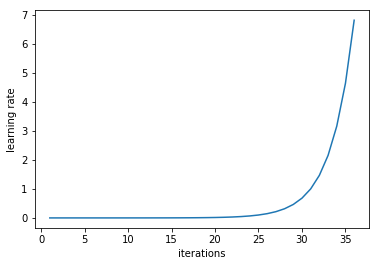

In [11]:
m.lr_find()
m.sched.plot_lr()

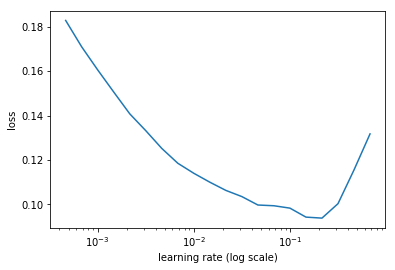

In [12]:
m.sched.plot()

We probably want the lr to be between 0.01 and 0.1, since it starts to show signs of overfitting at that point, exemplified by the loss increase after that point.

In [13]:
lr = 0.005
m.fit(lr, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.057912   0.016686  
    1      0.037447   0.018869                                                 
    2      0.033216   0.013065                                                 
    3      0.028638   0.017328                                                 
    4      0.027863   0.014116                                                 
    5      0.025146   0.014544                                                 
    6      0.035215   0.041494                                                 
    7      0.040618   0.012454                                                 
    8      0.035233   0.012508                                                 
    9      0.034502   0.028986                                                 
    10     0.032113   0.009205                                                 
    11     0.029615   0.016514                                                 
    12 

[array([0.01105])]

Looking good so far. The validation loss is now at a steady 0.023. Running a fresh .fit() call multiple times also produces vastly different results. Again, small dataset. One way to fix this could be bootstrap bagging and voting on predictions. Let's take a look at the test set now. Remember, 20% of the original data was put aside for the final test.

In [14]:
preds, targs = m.predict_with_targs()
num_correct = abs(preds - targs)
num_correct = len(num_correct[num_correct < 0.5])
print ('Testing accuracy: {:.2f}%'.format(num_correct/len(targs)*100))
print('{} incorrect predictions out of {}'.format(len(targs)-num_correct, len(targs)))

Testing accuracy: 98.76%
3 incorrect predictions out of 241


We got a nice 98.76% accuracy. Pretty good! That's 3 out of 241 instances. Perhaps with more data we could achieve better results? But with only 3000-ish samples this is pretty good. To confirm, lets check this with a stock sklearn RandomForestClassifier.

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40,
                              min_samples_leaf=2,
                              max_features=0.99,
                              oob_score=True)
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)

0.9826498422712934

So we did 0.5% better than a random forest with 40 estimators. That's impressive considering the RF learner is expected to perform relatively better than a deep net with such little data. Imagine if we had 10 times that number of samples for the deep learner to learn from!